In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings ('ignore')
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

from sklearn import metrics
from sklearn.metrics import roc_curve, auc

from numpy import mean
from numpy import std
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from matplotlib import pyplot
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


In [2]:
#Reading the data
df = pd.read_csv("consumer_complaints.csv")


In [3]:
#Printing 
print("Percentage of Rows with Null Values",(df['state'].isnull().sum()) * 100/(len(df)))

Percentage of Rows with Null Values 0.8790248166674761


In [4]:
# Dropping the column which have more than 60 percent null values
df = df.drop(['consumer_complaint_narrative', 'tags','consumer_consent_provided','company_public_response'], axis = 1)

In [5]:
# Dropping columns who have null values in any of the three columns 
mask1 = df['sub_product'].notnull()
mask2 = df['sub_issue'].notnull()
mask3 = df['state'].notnull()
mask4 = df['zipcode'].notnull()
dfnew = df[mask1 & mask2 & mask3 & mask4]
print(dfnew.shape)



(119910, 14)


In [6]:
print(dfnew.shape)
print(dfnew.columns)

(119910, 14)
Index(['date_received', 'product', 'sub_product', 'issue', 'sub_issue',
       'company', 'state', 'zipcode', 'submitted_via', 'date_sent_to_company',
       'company_response_to_consumer', 'timely_response', 'consumer_disputed?',
       'complaint_id'],
      dtype='object')


In [7]:
#converting each word into lowercase
dfnew['product'] = dfnew['product'].str.lower()
dfnew['sub_product'] = dfnew['sub_product'].str.lower()
dfnew['issue'] = dfnew['issue'].str.lower()
dfnew['sub_issue'] = dfnew['sub_issue'].str.lower()
dfnew['company'] = dfnew['company'].str.lower()
dfnew['company_response_to_consumer'] = dfnew['company_response_to_consumer'].str.lower()
dfnew['timely_response'] = dfnew['timely_response'].str.lower()
dfnew['submitted_via'] = dfnew['submitted_via'].str.lower()

In [8]:
#Adding columns year,month,day for date 
dfnew['date_received'] = pd.to_datetime(dfnew['date_received'])
dfnew['date_sent_to_company'] = pd.to_datetime(dfnew['date_sent_to_company'])
dfnew['date_sent_to_company_year'] = dfnew['date_sent_to_company'].dt.year
dfnew['date_sent_to_company_month'] = dfnew['date_sent_to_company'].dt.month
dfnew['date_sent_to_company_day'] = dfnew['date_sent_to_company'].dt.day


In [9]:
#Adding columns year,month,day for date 
dfnew['date_received'] = pd.to_datetime(dfnew['date_received'])
#extract the year
dfnew['date_received_year'] = dfnew['date_received'].dt.year
#extract the month
dfnew['date_received_month'] = dfnew['date_received'].dt.month
#extract the day
dfnew['ddate_received_day'] = dfnew['date_received'].dt.day

<p> To process the date, we need to convert the date column into year,month,day.</p>

In [10]:
# Dropping the date_received and date_sent_to_company
dfnew = dfnew.drop(['date_received', 'date_sent_to_company'], axis = 1)

In [11]:
import nltk
nltk.download('stopwords')
# For tokenization
nltk.download('punkt')
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vaish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vaish\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [13]:
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = sent.replace('-',' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [14]:
print(dfnew.columns)

Index(['product', 'sub_product', 'issue', 'sub_issue', 'company', 'state',
       'zipcode', 'submitted_via', 'company_response_to_consumer',
       'timely_response', 'consumer_disputed?', 'complaint_id',
       'date_sent_to_company_year', 'date_sent_to_company_month',
       'date_sent_to_company_day', 'date_received_year', 'date_received_month',
       'ddate_received_day'],
      dtype='object')


In [15]:

dfnew['sub_issue'] =  preprocess_text(dfnew['sub_issue'].values)


100%|███████████████████████████████████████████████████████████████████████| 119910/119910 [00:01<00:00, 97428.24it/s]


In [16]:
dfnew['company_response_to_consumer'] =  preprocess_text(dfnew['company_response_to_consumer'].values)

100%|██████████████████████████████████████████████████████████████████████| 119910/119910 [00:01<00:00, 106287.01it/s]


In [17]:
dfnew['issue'] =  preprocess_text(dfnew['issue'].values)

100%|███████████████████████████████████████████████████████████████████████| 119910/119910 [00:01<00:00, 95709.98it/s]


In [18]:
dfnew['sub_product'] =  preprocess_text(dfnew['sub_product'].values)

100%|██████████████████████████████████████████████████████████████████████| 119910/119910 [00:01<00:00, 106347.74it/s]


In [19]:
print(dfnew['zipcode'].value_counts())

300XX    326
770XX    315
750XX    303
900XX    245
330XX    230
        ... 
54755      1
49799      1
49461      1
65077      1
28305      1
Name: zipcode, Length: 17331, dtype: int64


In [20]:
#changing the target varaible label: yes=1 and no=0
dfnew['consumer_disputed?'] = np.where((dfnew['consumer_disputed?'] == 'Yes'), 1, 0)

In [21]:
print(dfnew['company_response_to_consumer'].value_counts())

closed explanation            90569
closed non monetary relief    18349
closed                         5137
closed monetary relief         2664
untimely response              1945
closed without relief           647
progress                        525
closed relief                    74
Name: company_response_to_consumer, dtype: int64


In [23]:
!pip install scikit-learn==0.24

In [24]:
#train test split
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(dfnew, test_size=0.2, stratify=dfnew['consumer_disputed?'], random_state=888)

y_train = X_train['consumer_disputed?']

y_test = X_test['consumer_disputed?']


In [25]:
#normalizing the column having numeric data
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['date_sent_to_company_year'].values.reshape(-1, 1))

X_train_normalized_company_year = normalizer.transform(X_train['date_sent_to_company_year'].values.reshape(-1,1))
X_test_normalized_company_year = normalizer.transform(X_test['date_sent_to_company_year'].values.reshape(-1,1))

normalizer.fit(X_train['date_sent_to_company_month'].values.reshape(-1, 1))

X_train_normalized_company_month = normalizer.transform(X_train['date_sent_to_company_month'].values.reshape(-1,1))
X_test_normalized_company_month = normalizer.transform(X_test['date_sent_to_company_month'].values.reshape(-1,1))

normalizer.fit(X_train['date_sent_to_company_day'].values.reshape(-1, 1))

X_train_normalized_company_day = normalizer.transform(X_train['date_sent_to_company_day'].values.reshape(-1,1))
X_test_normalized_company_day = normalizer.transform(X_test['date_sent_to_company_day'].values.reshape(-1,1))

normalizer.fit(X_train['date_received_year'].values.reshape(-1, 1))

X_train_normalized_received_year = normalizer.transform(X_train['date_received_year'].values.reshape(-1,1))
X_test_normalized_received_year = normalizer.transform(X_test['date_received_year'].values.reshape(-1,1))

normalizer.fit(X_train['date_received_month'].values.reshape(-1, 1))

X_train_normalized_received_month = normalizer.transform(X_train['date_received_month'].values.reshape(-1,1))
X_test_normalized_received_month = normalizer.transform(X_test['date_received_month'].values.reshape(-1,1))

normalizer.fit(X_train['ddate_received_day'].values.reshape(-1, 1))

X_train_normalized_received_day = normalizer.transform(X_train['ddate_received_day'].values.reshape(-1,1))
X_test_normalized_received_day = normalizer.transform(X_test['ddate_received_day'].values.reshape(-1,1))
print(X_train_normalized_received_day.shape)
normalizer.fit(X_train['complaint_id'].values.reshape(-1, 1))

X_train_normalized_complaint_id= normalizer.transform(X_train['complaint_id'].values.reshape(-1,1))
X_test_normalized_complaint_id = normalizer.transform(X_test['complaint_id'].values.reshape(-1,1))
print(X_train_normalized_complaint_id.shape)


(95928, 1)
(95928, 1)


In [30]:

#Response Coding
def responsedict(feature):
    #unique values of feature
    unique_labels = X_train[feature].unique()
    key = []
    val =[]
    for i in unique_labels:
       
        #Count where the target_variable is 1.
        positive = X_train.loc[:,feature][((X_train[feature] == i) & (y_train == 1))].count()
        #Count where the target_variable is 0.
        negative = X_train.loc[:,feature][((X_train[feature] == i) & (y_train == 0))].count()
        total_count = positive + negative
        #negative probability
        neg_prob = negative/total_count
        #positive probability
        pos_prob = positive/total_count
        key.append(i)
        val.append([neg_prob,pos_prob])
        
    prob_dict = dict(zip(key,val))
    
    return prob_dict

def feature_name(feature,df):
    feature_dict = responsedict(feature)
    #print(feature_dict)
    unique_label = X_train[feature].unique()
    fea = []
    for i,val  in df.iterrows():
        if val[feature] in unique_label:
            fea.append(feature_dict[val[feature]])
        else:
            fea.append([0.5,0.5])
   
    return fea
            
    
    
            

In [27]:
def hotencoder(dfeature):
    labelencoder = LabelEncoder()
    int_label_sub = labelencoder.fit_transform(dfeature)
    int_labe_sub = int_label_sub.reshape(len(int_label_sub),1)
    one_hot_encod_sub = OneHotEncoder(sparse=False)
    one_hot_enc = one_hot_encod_sub.fit_transform(int_labe_sub)
    return one_hot_enc
    

In [28]:
#one hot encoding
one_hot_enc_product_train =  hotencoder(X_train['product'])
one_hot_enc_product_test =  hotencoder(X_test['product'])
print("product",one_hot_enc_product_train.shape)
one_hot_enc_sub_product_train =  hotencoder(X_train['sub_product'])
one_hot_enc_sub_product_test =  hotencoder(X_test['sub_product'])
print("sub-product",one_hot_enc_sub_product_train.shape)
one_hot_enc_issue_train =  hotencoder(X_train['issue'])
one_hot_enc_issue_test =  hotencoder(X_test['issue'])
print("issue",one_hot_enc_issue_train.shape)
one_hot_enc_sub_issue_train =  hotencoder(X_train['sub_issue'])
one_hot_enc_sub_issue_test =  hotencoder(X_test['sub_issue'])
print("sub_issue",one_hot_enc_sub_issue_train.shape)

one_hot_enc_submitted_via_train =  hotencoder(X_train['submitted_via'])
one_hot_enc_submitted_via_test =  hotencoder(X_test['submitted_via'])
print("submitted",one_hot_enc_submitted_via_train.shape)
one_hot_enc__response_to_consumer_train =  hotencoder(X_train['company_response_to_consumer'])
one_hot_enc__response_to_consumer_test =  hotencoder(X_test['company_response_to_consumer'])
print("company response",one_hot_enc__response_to_consumer_train.shape)
one_hot_enc_timely_response_train =  hotencoder(X_train['timely_response'])
one_hot_enc_timely_response_test =  hotencoder(X_test['timely_response'])
print("timely response",one_hot_enc_timely_response_train.shape)

product (95928, 3)
sub-product (95928, 9)
issue (95928, 18)
sub_issue (95928, 47)
submitted (95928, 6)
company response (95928, 8)
timely response (95928, 2)


In [31]:
#response coding
train_product_responseCoding=np.array(feature_name('product',X_train))
#print(train_product_responseCoding.shape)
test_tproduct_responseCoding=np.array(feature_name('product',X_test))
#print(test_tproduct_responseCoding.shape)

train_sub_product_responseCoding=np.array(feature_name('sub_product',X_train))
test_sub_product_responseCoding=np.array(feature_name('sub_product',X_test))
#print(test_sub_product_responseCoding.shape)

train_issue_responseCoding=np.array(feature_name('issue',X_train))
test_issue_responseCoding=np.array(feature_name('issue',X_test))
#print(test_issue_responseCoding.shape)

train_sub_issue_responseCoding=np.array(feature_name('sub_issue',X_train))
print(train_sub_issue_responseCoding.shape)
test_sub_issue_responseCoding=np.array(feature_name('sub_issue',X_test))

train_zipcode_responseCoding=np.array(feature_name('zipcode',X_train))
test_zipcode_responseCoding=np.array(feature_name('zipcode',X_test))

train_company_response_responseCoding=np.array(feature_name('company_response_to_consumer',X_train))
test_company_response_responseCoding=np.array(feature_name('company_response_to_consumer',X_test))

train_company_responseCoding=np.array(feature_name('company',X_train))
test_company_responseCoding=np.array(feature_name('company',X_test))
#print(test_company_responseCoding.shape)

train_state_responseCoding=np.array(feature_name('state',X_train))
test_state_responseCoding=np.array(feature_name('state',X_test))


(95928, 2)


In [32]:
train_timely_response_responseCoding=np.array(feature_name('timely_response',X_train))
test_timely_response_responseCoding=np.array(feature_name('timely_response',X_test))


train_submitted_via_responseCoding=np.array(feature_name('submitted_via',X_train))
test_submitted_via_responseCoding=np.array(feature_name('submitted_via',X_test))


In [33]:
OneTrainXi = np.hstack((one_hot_enc_product_train,one_hot_enc_sub_product_train,one_hot_enc_issue_train,one_hot_enc_sub_issue_train,train_state_responseCoding,train_company_responseCoding,train_zipcode_responseCoding,one_hot_enc_submitted_via_train,one_hot_enc_timely_response_train,one_hot_enc__response_to_consumer_train,X_train_normalized_complaint_id,X_train_normalized_company_year,X_train_normalized_company_month,X_train_normalized_company_day,X_train_normalized_received_year,X_train_normalized_received_month,X_train_normalized_received_day))
OneTestXi = np.hstack((one_hot_enc_product_test,one_hot_enc_sub_product_test,one_hot_enc_issue_test,one_hot_enc_sub_issue_test,test_state_responseCoding,test_company_responseCoding,test_zipcode_responseCoding,one_hot_enc_submitted_via_test,one_hot_enc_timely_response_test,one_hot_enc__response_to_consumer_test,X_test_normalized_complaint_id,X_test_normalized_company_year,X_test_normalized_company_month,X_test_normalized_company_day,X_test_normalized_received_year,X_test_normalized_received_month,X_test_normalized_received_day))

In [34]:
print(OneTrainXi.shape)
print(OneTestXi.shape)

(95928, 106)
(23982, 106)


<h3> Oversampling the data using SMOTE </h3>

In [43]:
from imblearn.over_sampling import SMOTE

#from sklearn.utils.metaestimators import available_if
ros =SMOTE(random_state=777)
ros_xtrain, ros_train_y = ros.fit_resample(OneTrainXi, y_train)


In [44]:
print("After OverSampling, counts of label '1': {}".format(sum(ros_train_y == 'yes')))
print("After OverSampling, counts of label '0': {}".format(sum(ros_train_y == 'no')))

After OverSampling, counts of label '1': 0
After OverSampling, counts of label '0': 0


<h3> Logistic Regression </h3>

In [45]:
from sklearn.linear_model import LogisticRegression
# dict of parameters
grid={"C":np.logspace(-3,3,7),
     "solver" : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
     "penalty": ['l1', 'l2'],
     "max_iter": [100,200,300]}
logreg=LogisticRegression()
#Random search
logreg_cv=RandomizedSearchCV(logreg,grid,cv=10)
logreg_cv.fit(ros_xtrain, ros_train_y)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)

tuned hpyerparameters :(best parameters)  {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 200, 'C': 10.0}


In [46]:
solver = logreg_cv.best_params_['solver']
penalty = logreg_cv.best_params_['penalty']
max_iter = logreg_cv.best_params_['max_iter']
c = logreg_cv.best_params_['C']


Test confusion matrix


Text(33.0, 0.5, 'Actual label')

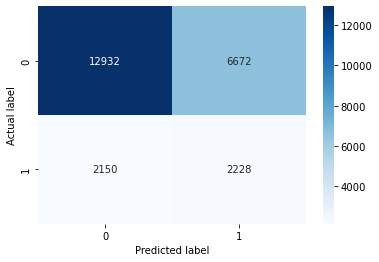

In [47]:
#using best parameters
import pickle
logistic = LogisticRegression(C=c,penalty=penalty,solver=solver,max_iter=max_iter)
logistic.fit(ros_xtrain, ros_train_y)
             
# save the model to disk
filename = 'resfinalized_model.sav'
pickle.dump(logistic, open(filename, 'wb'))
             
ypred = logistic.predict(OneTestXi)
print("Test confusion matrix")
#plot confusion matrix
cntestlog = confusion_matrix(X_test['consumer_disputed?'],ypred)
sns.heatmap(cntestlog, annot=True,fmt="d",cmap='Blues')

plt.xlabel("Predicted label")
plt.ylabel("Actual label")

In [48]:
#Accuracy of the model
Accuracy = (cntestlog[0][0] + cntestlog[1][1]) / (cntestlog[0][0] + cntestlog[1][1] + cntestlog[0][1] + cntestlog[1][0])
print("Accuracy log test",Accuracy)

Accuracy log test 0.6321407722458511


Train confusion matrix


Text(33.0, 0.5, 'Actual label')

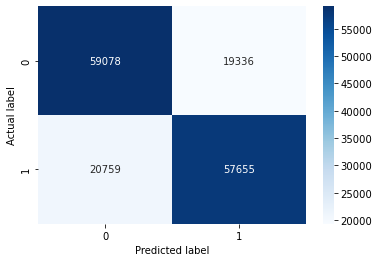

In [51]:
ytrainpred = logistic.predict(ros_xtrain)
print("Train confusion matrix")
#plot confusion matrix
cnlogtrain = confusion_matrix(ros_train_y,ytrainpred)
sns.heatmap(cnlogtrain, annot=True,fmt="d",cmap='Blues')

plt.xlabel("Predicted label")
plt.ylabel("Actual label")

In [52]:
#Accuracy of the model
Accuracy = (cnlogtrain[0][0] + cnlogtrain[1][1]) / (cnlogtrain[0][0] + cnlogtrain[1][1] + cnlogtrain[0][1] + cnlogtrain[1][0])
print("Accuracy log train",Accuracy)

Accuracy log train 0.7443377458106971


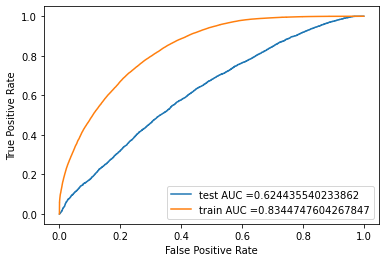

In [54]:
#computing prob. of getting the target variable to compute the AUC score
y_train_proba = logistic.predict_proba(ros_xtrain)[::,1]
y_proba_pred = logistic.predict_proba(OneTestXi)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_proba_pred)
fprtrain,tprtrain,_ = metrics.roc_curve(ros_train_y,y_train_proba)
#create ROC curve
plt.plot(fpr,tpr,label="test AUC ="+str(auc(fpr,tpr)))
plt.plot(fprtrain,tprtrain,label="train AUC ="+str(auc(fprtrain,tprtrain)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()


<ul> Observations:
    <li> Accuracy = 63% </li>
    <li> AUC = 0.622 </li>
    <li> False positive is high.</li>

<h3> Decision Tree Classifier </h3>

In [55]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
model = DecisionTreeClassifier()
# parameters dict
params = {
    'max_depth' : [1, 3, 10, 30,45],
    'min_samples_split' : [5, 10, 100, 500,1000],
    "min_samples_leaf": [1,3,4,5,6,7],
    "criterion": ["gini", "entropy"]
}
#Randomsearch
clf = RandomizedSearchCV(model,params,cv=3,scoring='roc_auc',return_train_score=True)
clf.fit(ros_xtrain,ros_train_y)



max_depth = clf.cv_results_['param_max_depth']
#best parameter
best_para = clf.best_params_
print(best_para)

{'min_samples_split': 1000, 'min_samples_leaf': 6, 'max_depth': 45, 'criterion': 'gini'}


In [56]:
min_sample = clf.best_params_['min_samples_split']
min_sample =  clf.best_params_['min_samples_split']
max_depth = clf.best_params_['max_depth']
criter =  clf.best_params_['criterion']

Test confusion matrix


Text(33.0, 0.5, 'Actual label')

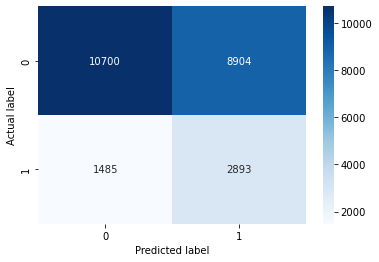

In [57]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(ros_xtrain, ros_train_y)
ypred = nb.predict(OneTestXi)
print("Test confusion matrix")
#plot confusion matrix
cntestnaive = confusion_matrix(X_test['consumer_disputed?'],ypred)
sns.heatmap(cntestnaive, annot=True,fmt="d",cmap='Blues')

plt.xlabel("Predicted label")
plt.ylabel("Actual label")

Test confusion matrix


Text(33.0, 0.5, 'Actual label')

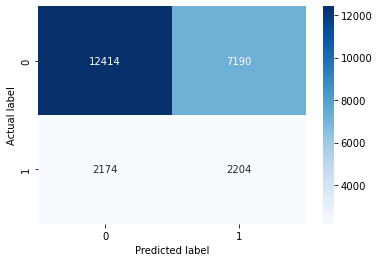

In [58]:
#training model with best parameters found using randomsearch
clfnewd = DecisionTreeClassifier(min_samples_split = min_sample,min_samples_leaf=min_sample,max_depth=max_depth,criterion=criter)
clfnewd.fit(ros_xtrain,ros_train_y)
#Presicting values for test samples
ydpred = clfnewd.predict(OneTestXi)
print("Test confusion matrix")
#Plot confusion matrix
cn2 = confusion_matrix(X_test['consumer_disputed?'],ydpred)
sns.heatmap(cn2, annot=True,fmt="d",cmap='Blues')

plt.xlabel("Predicted label")
plt.ylabel("Actual label")

In [59]:
#Accuracy of model test
Accuracy = (cn2[0][0] + cn2[1][1]) / (cn2[0][0] + cn2[1][1] + cn2[0][1] + cn2[1][0])
print("Accuracy",Accuracy)

Accuracy 0.6095404886998582


Train confusion matrix


Text(33.0, 0.5, 'Actual label')

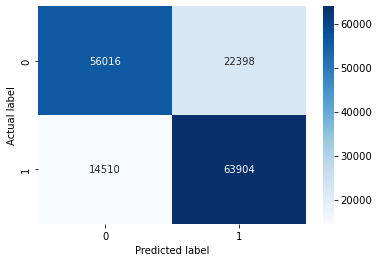

In [60]:
ytrainpred = clfnewd.predict(ros_xtrain)
print("Train confusion matrix")
#Plot confusion matrix for Train samples
cn3 = confusion_matrix(ros_train_y,ytrainpred)
sns.heatmap(cn3, annot=True,fmt="d",cmap='Blues')

plt.xlabel("Predicted label")
plt.ylabel("Actual label")

In [61]:
#Accuracy of model train
Accuracy = (cn3[0][0] + cn3[1][1]) / (cn3[0][0] + cn3[1][1] + cn3[0][1] + cn3[1][0])
print("Accuracy",Accuracy)

Accuracy 0.7646593720509093


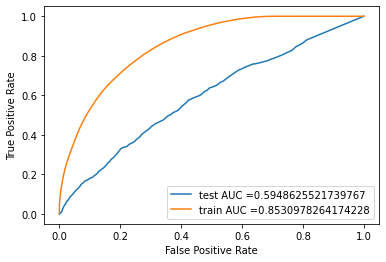

In [62]:
#computing prob. of getting the target variable to compute the AUC score
y_train_proba = clfnewd.predict_proba(ros_xtrain)[::,1]
y_proba_pred = clfnewd.predict_proba(OneTestXi)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_proba_pred)
fprtrain,tprtrain,_ = metrics.roc_curve(ros_train_y,y_train_proba)
#create ROC curve
plt.plot(fpr,tpr,label="test AUC ="+str(auc(fpr,tpr)))
plt.plot(fprtrain,tprtrain,label="train AUC ="+str(auc(fprtrain,tprtrain)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

<ul> Observations:
    <li> Accuracy = 60% </li>
    <li> AUC = 0.59 </li>

<h3> Xgboost </h3>

In [65]:
from xgboost import XGBClassifier
params = {
 'learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
 'max_depth' : [ 3, 4, 5, 6, 8, 10, 12, 15],
 
 'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 'colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7 ]
}
xgbc = XGBClassifier()
#Random search
rs_model=RandomizedSearchCV(xgbc,param_distributions=params,n_iter=5,scoring='roc_auc',cv=5)
rs_model.fit(ros_xtrain,ros_train_y)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           min_child_weight=None, missing=nan,
                                           monotone_constra

In [66]:
#Best parameters
print("Best Parameters",rs_model.best_params_)
max_depth = rs_model.best_params_['max_depth']
learning = rs_model.best_params_['learning_rate']
gamma = rs_model.best_params_['gamma']
colsam = rs_model.best_params_['colsample_bytree']


Best Parameters {'max_depth': 15, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.7}


In [67]:
# Training model using best parameters
xbb = XGBClassifier(max_depth=max_depth,learning_rate=learning,gamma=gamma,colsample_bytree=colsam)
xbb.fit(ros_xtrain,ros_train_y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.1, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=15, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

Text(33.0, 0.5, 'Actual label')

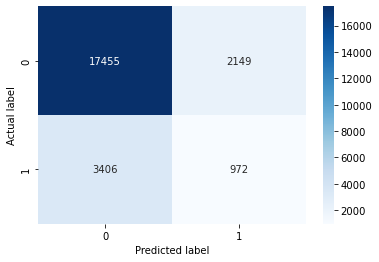

In [68]:
ypred = xbb.predict(OneTestXi)
#plot confusion matrix for test samples
cxgbtest= confusion_matrix(y_test,ypred)
sns.heatmap(cxgbtest, annot=True,fmt="d",cmap='Blues')

plt.xlabel("Predicted label")
plt.ylabel("Actual label")

In [69]:
#Accuracy of the model test
Accuracy = (cxgbtest[0][0] + cxgbtest[1][1]) / (cxgbtest[0][0] + cxgbtest[1][1] + cxgbtest[0][1] + cxgbtest[1][0])
print("Accuracy test xgb",Accuracy)

Accuracy test xgb 0.7683679426236344


Train confusion matrix


Text(33.0, 0.5, 'Actual label')

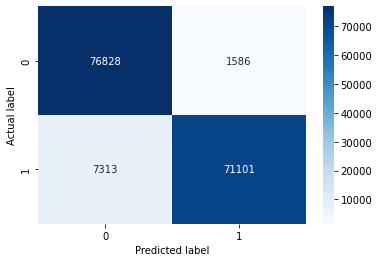

In [70]:
ytrainpred = xbb.predict(ros_xtrain)
print("Train confusion matrix")
#plot confusion for train set
cxgbtrain = confusion_matrix(ros_train_y,ytrainpred)
sns.heatmap(cxgbtrain, annot=True,fmt="d",cmap='Blues')

plt.xlabel("Predicted label")
plt.ylabel("Actual label")

In [71]:
#Accuracy of the model
Accuracy = (cxgbtrain[0][0] + cxgbtrain[1][1]) / (cxgbtrain[0][0] + cxgbtrain[1][1] + cxgbtrain[0][1] + cxgbtrain[1][0])
print("Accuracy",Accuracy)

Accuracy 0.9432563062718392


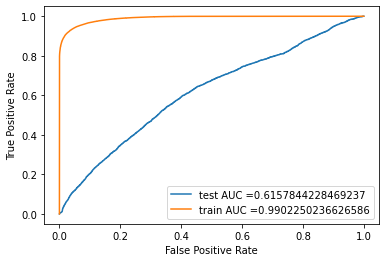

In [72]:
#computing prob. of getting the target variable to compute the AUC score
y_train_proba = xbb.predict_proba(ros_xtrain)[::,1]
y_proba_pred = xbb.predict_proba(OneTestXi)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_proba_pred)
fprtrain,tprtrain,_ = metrics.roc_curve(ros_train_y,y_train_proba)
#create ROC curve
plt.plot(fpr,tpr,label="test AUC ="+str(auc(fpr,tpr)))
plt.plot(fprtrain,tprtrain,label="train AUC ="+str(auc(fprtrain,tprtrain)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

<ul> Observations:
    <li> Accuracy = 76.8% </li>
    <li> AUC = 0.61 </li>
    <li> False negative is high.</li>

<h3> Random Forest </h3>

In [73]:
from sklearn.ensemble import RandomForestClassifier
parameters = {
    'n_estimators'      : [320,330,340,400,500],
    'max_depth'         : [8, 9, 10, 11, 12,15,18],
    'criterion'         : ['gini', 'entropy', 'log_loss'],
    'max_leaf_nodes'    : [3,6,8,1,2,4,5]
    
}
model = RandomForestClassifier()
#Randomsearch
clfrandom = RandomizedSearchCV(model,parameters,cv=3,scoring='roc_auc',return_train_score=True)
clfrandom.fit(ros_xtrain,ros_train_y)


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [8, 9, 10, 11, 12, 15, 18],
                                        'max_leaf_nodes': [3, 6, 8, 1, 2, 4, 5],
                                        'n_estimators': [320, 330, 340, 400,
                                                         500]},
                   return_train_score=True, scoring='roc_auc')

In [74]:
print("Best param",clfrandom.best_params_)

Best param {'n_estimators': 400, 'max_leaf_nodes': 5, 'max_depth': 9, 'criterion': 'gini'}


In [75]:
n_estimator = clfrandom.best_params_['n_estimators']
max_depth = clfrandom.best_params_['max_depth'] 
criterion = clfrandom.best_params_['criterion'] 
max_leaf_nodes = clfrandom.best_params_['max_leaf_nodes'] 

Test confusion matrix


Text(33.0, 0.5, 'Actual label')

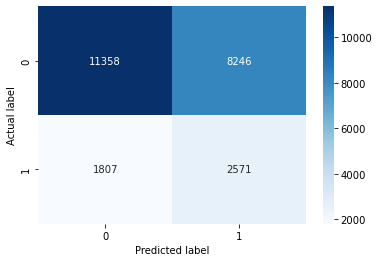

In [76]:
#training the model using best parameters
modelrandom = RandomForestClassifier(n_estimators=n_estimator,max_depth=max_depth,criterion=criterion,max_leaf_nodes=max_leaf_nodes)
modelrandom.fit(ros_xtrain,ros_train_y)
ydpred = modelrandom.predict(OneTestXi)
print("Test confusion matrix")
#plot test confusion matrix
cnr = confusion_matrix(X_test['consumer_disputed?'],ydpred)
sns.heatmap(cnr, annot=True,fmt="d",cmap='Blues')

plt.xlabel("Predicted label")
plt.ylabel("Actual label")


In [77]:
#Accuracy of the model
Accuracy = (cnr[0][0] + cnr[1][1]) / (cnr[0][0] + cnr[1][1] + cnr[0][1] + cnr[1][0])
print("Accuracy test",Accuracy)

Accuracy test 0.580810607955967


Train confusion matrix


Text(33.0, 0.5, 'Actual label')

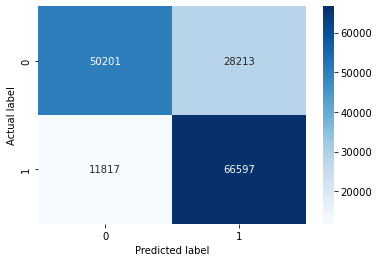

In [78]:
ytrainpred = modelrandom.predict(ros_xtrain)
print("Train confusion matrix")
#Plot confusion matrix for Train samples
cnrandtrain = confusion_matrix(ros_train_y,ytrainpred)
sns.heatmap(cnrandtrain, annot=True,fmt="d",cmap='Blues')

plt.xlabel("Predicted label")
plt.ylabel("Actual label")

In [79]:
#Accuracy of the model
Accuracy = (cnrandtrain[0][0] + cnrandtrain[1][1]) / (cnrandtrain[0][0] + cnrandtrain[1][1] + cnrandtrain[0][1] + cnrandtrain[1][0])
print("Accuracy train",Accuracy)

Accuracy train 0.7447522126150943


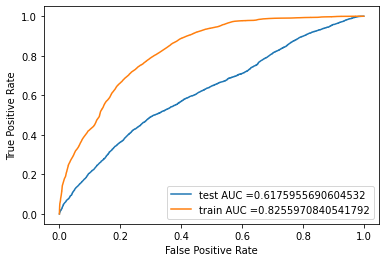

In [81]:
from sklearn.metrics import roc_curve, auc
#computing prob. of getting the target variable to compute the AUC score
y_train_proba = modelrandom.predict_proba(ros_xtrain)[::,1]
y_proba_pred = modelrandom.predict_proba(OneTestXi)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_proba_pred)
fprtrain,tprtrain,_ = metrics.roc_curve(ros_train_y,y_train_proba)
#create ROC curve
plt.plot(fpr,tpr,label="test AUC ="+str(auc(fpr,tpr)))
plt.plot(fprtrain,tprtrain,label="train AUC ="+str(auc(fprtrain,tprtrain)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

<ul> Observations:
    <li> Accuracy = 58% </li>
    <li> AUC = 0.621 </li>
    <li> False positive is high.</li>

<h3> Stacking </h3>

In [82]:
# define the models for level 0
level0 = list()
level0.append(('lr', LogisticRegression(C=c,penalty=penalty,solver=solver,max_iter=max_iter)))
level0.append(('knn', KNeighborsClassifier()))
level0.append(('cart', DecisionTreeClassifier(min_samples_split = min_sample,min_samples_leaf=min_sample,max_depth=max_depth,criterion=criter)))
level0.append(('bayes', GaussianNB()))
# model for the last stage
level1 = LogisticRegression()
modelstack = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
modelstack.fit(ros_xtrain,ros_train_y)
yhat = modelstack.predict(OneTestXi)

Test confusion matrix


Text(33.0, 0.5, 'Actual label')

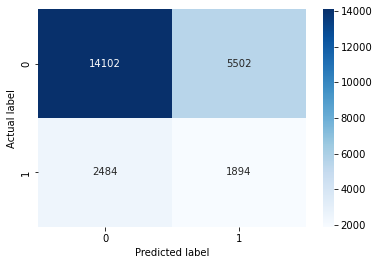

In [83]:
print("Test confusion matrix")
#plot confusion matrix for test samples
cns = confusion_matrix(X_test['consumer_disputed?'],yhat)
sns.heatmap(cns, annot=True,fmt="d",cmap='Blues')

plt.xlabel("Predicted label")
plt.ylabel("Actual label")

In [84]:
#Test Accuracy of the model
Accuracy = (cns[0][0] + cns[1][1]) / (cns[0][0] + cns[1][1] + cns[0][1] + cns[1][0])
print("Accuracy stacking test",Accuracy)

Accuracy stacking test 0.6670002501876408


Train confusion matrix


Text(33.0, 0.5, 'Actual label')

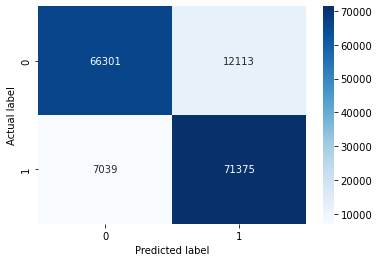

In [85]:
ytrainpred = modelstack.predict(ros_xtrain)
print("Train confusion matrix")
#Plot confusion matrix for Train samples
stacktrain = confusion_matrix(ros_train_y,ytrainpred)
sns.heatmap(stacktrain, annot=True,fmt="d",cmap='Blues')

plt.xlabel("Predicted label")
plt.ylabel("Actual label")

In [87]:
#Accuracy of the model
Accuracy = (stacktrain[0][0] + stacktrain[1][1]) / (stacktrain[0][0] + stacktrain[1][1] + stacktrain[0][1] + stacktrain[1][0])
print("Accuracy stack train",Accuracy)

Accuracy stack train 0.8778789501874665


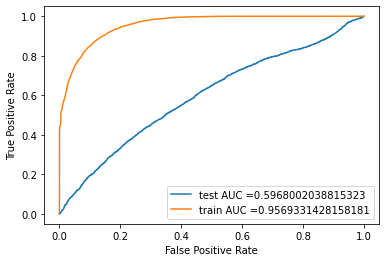

In [86]:
from sklearn.metrics import roc_curve, auc
#computing prob. of getting the target variable to compute the AUC score
y_train_proba = modelstack.predict_proba(ros_xtrain)[::,1]
y_proba_pred = modelstack.predict_proba(OneTestXi)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_proba_pred)
fprtrain,tprtrain,_ = metrics.roc_curve(ros_train_y,y_train_proba)
#create ROC curve
plt.plot(fpr,tpr,label="test AUC ="+str(auc(fpr,tpr)))
plt.plot(fprtrain,tprtrain,label="train AUC ="+str(auc(fprtrain,tprtrain)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

<ul> Observations:
    <li> Accuracy = 71% </li>
    <li> AUC = 0.605 </li>
    <li> False positive is high.</li>

In [90]:
from prettytable import PrettyTable
  

# adding column headers
newTable = PrettyTable(["Model", "Train AUC", "Test AUC"," Train Accuracy","Test Accuracy"])
  
# Add rows
newTable.add_row(["Logistic Regression","0.83","0.622", "0.74","0.63"])
newTable.add_row(["Decision Tree","0.90" ,"0.584", "0.76","0.60"])
newTable.add_row(["Xgboost", "0.96","0.610", "0.90","0.76"])
newTable.add_row(["RandomForest","0.92","0.619", "0.75","0.5"])
newTable.add_row(["Stacking", "0.95","0.599", "0.87","0.66"])

  
print(newTable)

+---------------------+-----------+----------+-----------------+---------------+
|        Model        | Train AUC | Test AUC |  Train Accuracy | Test Accuracy |
+---------------------+-----------+----------+-----------------+---------------+
| Logistic Regression |    0.83   |  0.622   |       0.74      |      0.63     |
|    Decision Tree    |    0.90   |  0.584   |       0.76      |      0.60     |
|       Xgboost       |    0.96   |  0.610   |       0.90      |      0.76     |
|     RandomForest    |    0.92   |  0.619   |       0.75      |      0.5      |
|       Stacking      |    0.95   |  0.599   |       0.87      |      0.66     |
+---------------------+-----------+----------+-----------------+---------------+


<h3>Summary</h3>
<p> Due to the presence of large no. of False Positives ,AUC is low for all the models.Xgboost and logistic regression model is good choice for this case study.</p> 

<h3> PCA for Feature importance </h3>

In [91]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
df1=pd.DataFrame(ros_xtrain, ros_train_y)
 
# Scale data before applying PCA
scaling=StandardScaler()
 
# Use fit and transform method
scaling.fit(df1)
Scaled_data=scaling.transform(df1)
 
# Set the n_components=2
principal=PCA(n_components=106)
principal.fit(Scaled_data)
x=principal.transform(Scaled_data)
 
# Check the dimensions of data after PCA
print(x.shape)

(156828, 106)


<p>The importance of each eigenvector is depicted by its corresponding eigenvalue.</p>

In [93]:
print(abs(principal.components_[0]))

[0.42622637 0.08622124 0.42023965 0.02582628 0.08575863 0.11766975
 0.01990562 0.09525341 0.07447373 0.0348263  0.40338797 0.03986697
 0.02130586 0.01919561 0.05804464 0.06393613 0.16169334 0.03433261
 0.24403545 0.08239426 0.04479507 0.07170844 0.03846675 0.02324787
 0.13196736 0.02600905 0.18817043 0.20287628 0.02608276 0.03574482
 0.08364393 0.02130586 0.03966739 0.01074551 0.01151562 0.01654317
 0.01919561 0.05804464 0.03433261 0.01983167 0.01615206 0.00659742
 0.02380442 0.12006325 0.0682539  0.03244452 0.11794705 0.01808541
 0.04760424 0.12110065 0.04554327 0.06611537 0.0136315  0.01132654
 0.00838746 0.07595955 0.06732637 0.02324787 0.09917104 0.13196736
 0.03516477 0.04275243 0.10504529 0.02600905 0.20287628 0.03916266
 0.01400254 0.02608276 0.0080872  0.01525426 0.02695672 0.07832134
 0.01555942 0.01941053 0.02785437 0.1378868  0.01751478 0.00557798
 0.00557798 0.0209459  0.0209459  0.00615585 0.00615585 0.00430051
 0.00854882 0.02043712 0.0215921  0.00602913 0.02196333 0.0487

<p><b>complaint_id,date_sent_to_company_year,date_sent_to_company_month,
    date_sent_to_company_day,date_received_year,date_received_month,ddate_received_day </b>
    not contribute at all .So we can drop them.</p>

<h3>Conclusion </h3>
<ol> <b> For Principal Component 1 important features in desc. order are</b>
<li>sub-issue </li>
<li>issue</li>
<li> sub-product </li>
<li> product</li>
<li> company </li>
<li> zipcode </li>
<li> state </li>
<li> company response </li>
<li> timely response </li>
<li> submitted_via </li>



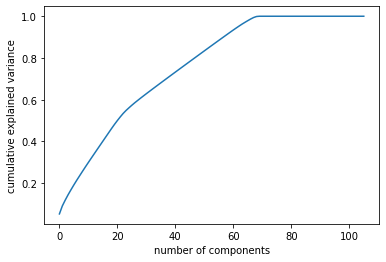

In [94]:
plt.plot(np.cumsum(principal.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

<p>From the above plot we could infer that after 14 features variance is not changing much.So we can drop all other features</p>